# Part 4: Models

# Import Necessary Libraries

In [1]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Directory

In [2]:
train_dir = 'split/train'
train_CORROSION_dir = 'split/train/CORROSION/'
train_NOCORROSION_dir = 'split/train/NOCORROSION/'

validation_dir = 'split/validation'
validation_CORROSION_dir = 'split/validation/CORROSION/'
validation_NOCORROSION_dir = 'split/validation/NOCORROSION/'

test_dir = 'split/test'
test_CORROSION_dir = 'split/test/CORROSION/'
test_NOCORROSION_dir = 'split/test/NOCORROSION/'

In [3]:
def num_files_in_direcotry(path):
    num = len([file for file in os.listdir(path) if file.endswith('.jpg')])
    return num

In [4]:
train_CORROSION_num = num_files_in_direcotry(train_CORROSION_dir)
train_NOCORROSION_num = num_files_in_direcotry(train_NOCORROSION_dir)
train_SUM_num = train_CORROSION_num + train_NOCORROSION_num

print("[Train] Number of CORROSION Images: ", train_CORROSION_num)
print("[Train] Number of NOCORROSION Images: ", train_NOCORROSION_num)
print("[Train] Number of TOTAL Images: ", train_SUM_num)

[Train] Number of CORROSION Images:  693
[Train] Number of NOCORROSION Images:  580
[Train] Number of TOTAL Images:  1273


In [5]:
val_CORROSION_num = num_files_in_direcotry(validation_CORROSION_dir)
val_NOCORROSION_num = num_files_in_direcotry(validation_NOCORROSION_dir)
val_SUM_num = val_CORROSION_num + val_NOCORROSION_num

print("[Validation] Number of CORROSION Images: ", val_CORROSION_num)
print("[Validation] Number of NOCORROSION Images: ", val_NOCORROSION_num)
print("[Validation] Number of TOTAL Images: ", val_SUM_num)

[Validation] Number of CORROSION Images:  198
[Validation] Number of NOCORROSION Images:  166
[Validation] Number of TOTAL Images:  364


In [6]:
test_CORROSION_num = num_files_in_direcotry(test_CORROSION_dir)
test_NOCORROSION_num = num_files_in_direcotry(test_NOCORROSION_dir)
test_SUM_num = test_CORROSION_num + test_NOCORROSION_num

print("[Test] Number of CORROSION Images: ", test_CORROSION_num)
print("[Test] Number of NOCORROSION Images: ", test_NOCORROSION_num)
print("[Test] Number of TOTAL Images: ", test_SUM_num)

[Test] Number of CORROSION Images:  99
[Test] Number of NOCORROSION Images:  83
[Test] Number of TOTAL Images:  182


# Function for results visualization

In [7]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation accuracy
    train_auc = cnn_model.history['acc']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [8]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (128,128),
                                         batch_size = 32,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42
                                         )
        generator_lst.append(g)
    
    return generator_lst

In [9]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


# Model 1: Baseline Model

In [10]:
 # Design the model
    
def build_model_1():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    

    cnn.add(Flatten())

    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn = build_model_1()

In [11]:
# Train the model

cnn_model = cnn.fit_generator(train_generator,
                              epochs = 20,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_5340\1447062415.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = cnn.fit_generator(train_generator,


Epoch 1/20
40/40 [==============================] - 63s 2s/step - loss: 0.6369 - acc: 0.6339 - val_loss: 0.6031 - val_acc: 0.7143
Epoch 2/20
40/40 [==============================] - 57s 1s/step - loss: 0.5603 - acc: 0.7353 - val_loss: 0.5846 - val_acc: 0.6896
Epoch 3/20
40/40 [==============================] - 527s 13s/step - loss: 0.5239 - acc: 0.7557 - val_loss: 0.5095 - val_acc: 0.7610
Epoch 4/20
40/40 [==============================] - 56s 1s/step - loss: 0.4824 - acc: 0.7730 - val_loss: 0.6232 - val_acc: 0.7143
Epoch 5/20
40/40 [==============================] - 54s 1s/step - loss: 0.4940 - acc: 0.7800 - val_loss: 0.5208 - val_acc: 0.7500
Epoch 6/20
40/40 [==============================] - 55s 1s/step - loss: 0.4829 - acc: 0.7816 - val_loss: 0.5073 - val_acc: 0.7885
Epoch 7/20
40/40 [==============================] - 55s 1s/step - loss: 0.4116 - acc: 0.8130 - val_loss: 0.5420 - val_acc: 0.7390
Epoch 8/20
40/40 [==============================] - 54s 1s/step - loss: 0.4218 - acc: 0.

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_5340\2413494331.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 85.16% | Precision = 85.29% | Recall = 87.88% | Specificity = 81.93% | F1 Score = 86.57%


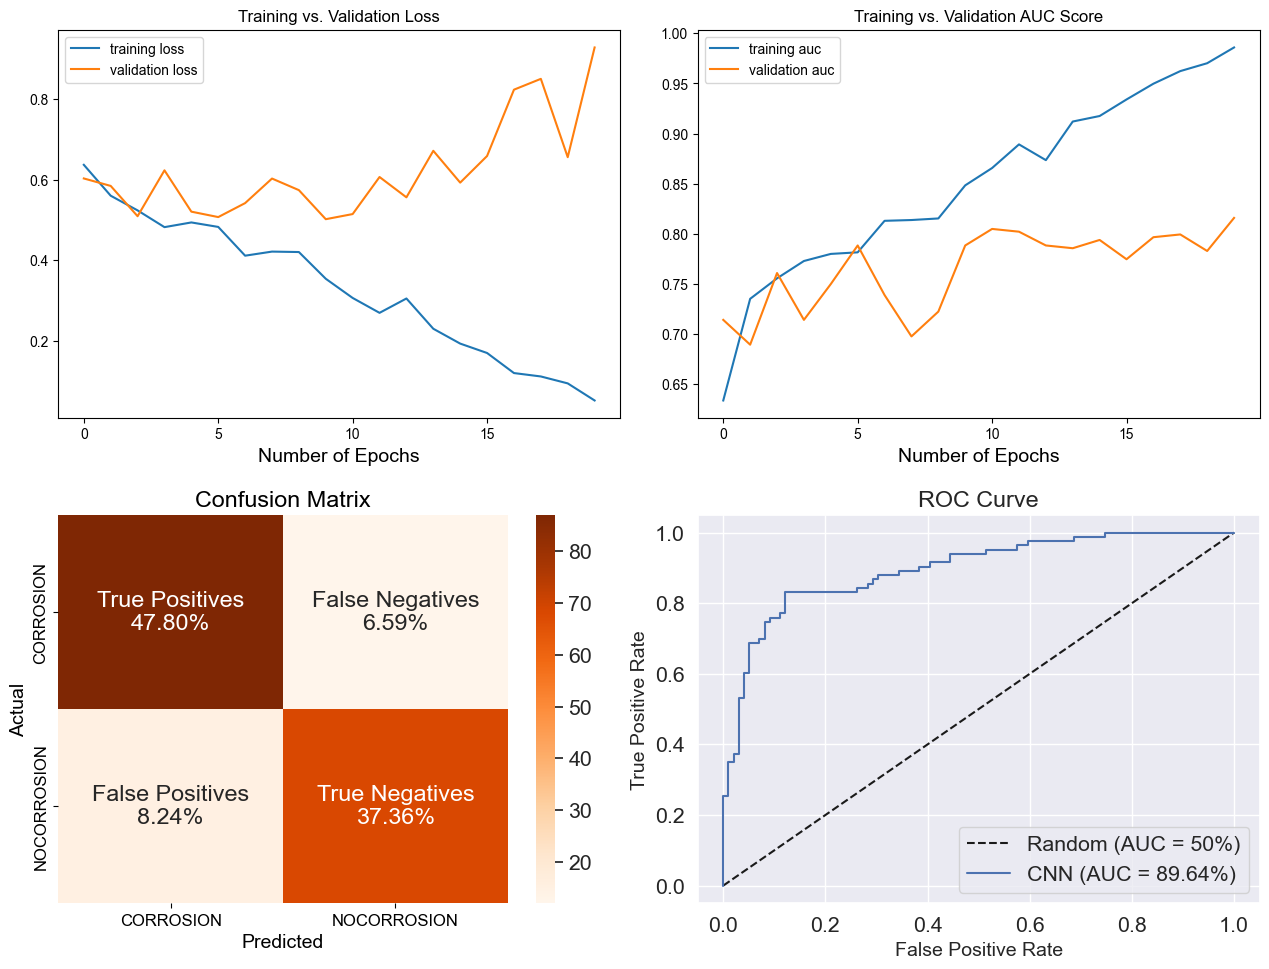

In [12]:
create_charts(cnn,cnn_model)

In the beginning, the validation loss goes down. But at epoch 7 this stops and the validation loss starts increasing rapidly. This is when the model begins to be overfitting. The training loss continues to go down and almost reaches zero at epoch 20. This is normal as the model is trained to fit the train data as good as possible.

Now, we need to do something about the overfitting. There are different options to do that:
- Data augmentation: data augmentation is an excellent practice to add more data to the existing dataset and add minor alterations and diversity to avoid the model from overfitting to training data.
- l1&l2 regulations: apply regulation, which comes down to adding a cost to the loss function for large weights.
- Dropout layers: use dropout layers, which will randomly remove certain features by setting them to zero.
- Batch normalization: normalize the input layer by adjusting and scaling the activations. 

# Model 2: Data Augmentation, Epoch = 30

In [13]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [14]:
cnn_model_2 = cnn.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_5340\920489767.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model_2 = cnn.fit_generator(train_generator,


Epoch 1/30
40/40 [==============================] - 57s 1s/step - loss: 0.5391 - acc: 0.8020 - val_loss: 0.5027 - val_acc: 0.7692
Epoch 2/30
40/40 [==============================] - 55s 1s/step - loss: 0.4009 - acc: 0.8280 - val_loss: 0.4639 - val_acc: 0.8132
Epoch 3/30
40/40 [==============================] - 57s 1s/step - loss: 0.3846 - acc: 0.8397 - val_loss: 0.4916 - val_acc: 0.7885
Epoch 4/30
40/40 [==============================] - 55s 1s/step - loss: 0.3623 - acc: 0.8523 - val_loss: 0.4637 - val_acc: 0.8022
Epoch 5/30
40/40 [==============================] - 55s 1s/step - loss: 0.3602 - acc: 0.8507 - val_loss: 0.4932 - val_acc: 0.7912
Epoch 6/30
40/40 [==============================] - 74s 2s/step - loss: 0.3762 - acc: 0.8374 - val_loss: 0.5889 - val_acc: 0.7555
Epoch 7/30
40/40 [==============================] - 59s 1s/step - loss: 0.3408 - acc: 0.8578 - val_loss: 0.5013 - val_acc: 0.8049
Epoch 8/30
40/40 [==============================] - 59s 1s/step - loss: 0.3152 - acc: 0.87

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_5340\2413494331.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 84.62% | Precision = 88.17% | Recall = 82.83% | Specificity = 86.75% | F1 Score = 85.42%


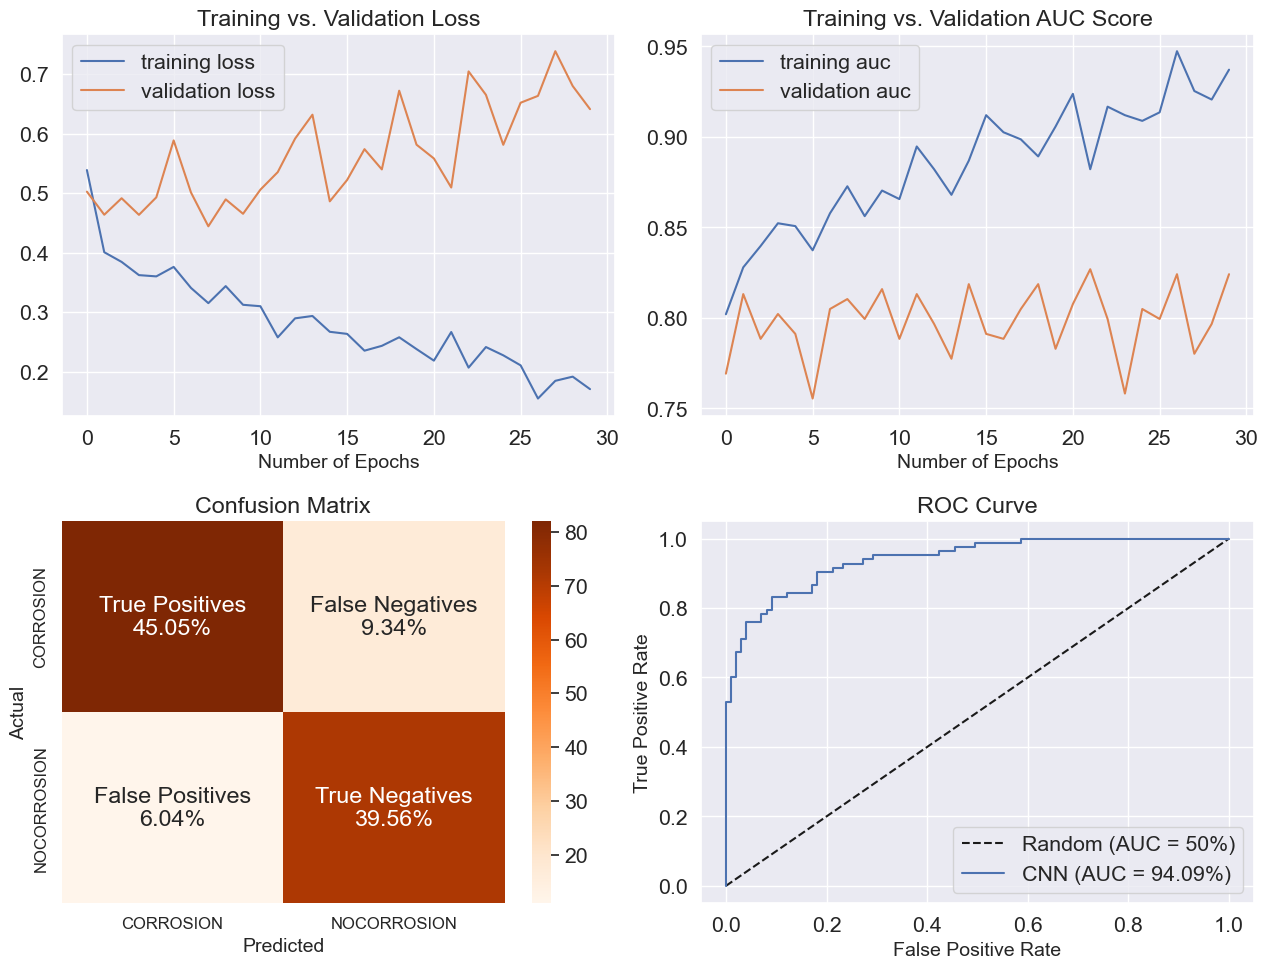

In [15]:
create_charts(cnn,cnn_model_2)

From training vs validation loss curves, it can be seen that the training model still have overfitting issues.

# Model3: Dropout = 0.1, Dropout = 0.2, Dropout = 0.25, Dense = 128, Epoch = 40, Early Stopping 

In [16]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

In [17]:
 # Design the model
    
def build_model_3():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.25))
    

    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_3 = build_model_3()

In [18]:
cnn_model_3 = cnn_3.fit_generator(train_generator,
                              epochs = 40,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_5340\3026494806.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model_3 = cnn_3.fit_generator(train_generator,


Epoch 1/40
40/40 [==============================] - 29s 711ms/step - loss: 0.6862 - acc: 0.5452 - val_loss: 0.6408 - val_acc: 0.6868
Epoch 2/40
40/40 [==============================] - 28s 691ms/step - loss: 0.5973 - acc: 0.6764 - val_loss: 0.6162 - val_acc: 0.6951
Epoch 3/40
40/40 [==============================] - 28s 696ms/step - loss: 0.5796 - acc: 0.7038 - val_loss: 0.5462 - val_acc: 0.7390
Epoch 4/40
40/40 [==============================] - 28s 692ms/step - loss: 0.5468 - acc: 0.7227 - val_loss: 0.5303 - val_acc: 0.7610
Epoch 5/40
40/40 [==============================] - 28s 689ms/step - loss: 0.5360 - acc: 0.7353 - val_loss: 0.5261 - val_acc: 0.7582
Epoch 6/40
40/40 [==============================] - 27s 682ms/step - loss: 0.5000 - acc: 0.7533 - val_loss: 0.6512 - val_acc: 0.7418
Epoch 7/40
40/40 [==============================] - 28s 698ms/step - loss: 0.5278 - acc: 0.7518 - val_loss: 0.5833 - val_acc: 0.7115
Epoch 8/40
40/40 [==============================] - 28s 690ms/step - 

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_5340\2413494331.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 75.27% | Precision = 87.50% | Recall = 63.64% | Specificity = 89.16% | F1 Score = 73.68%


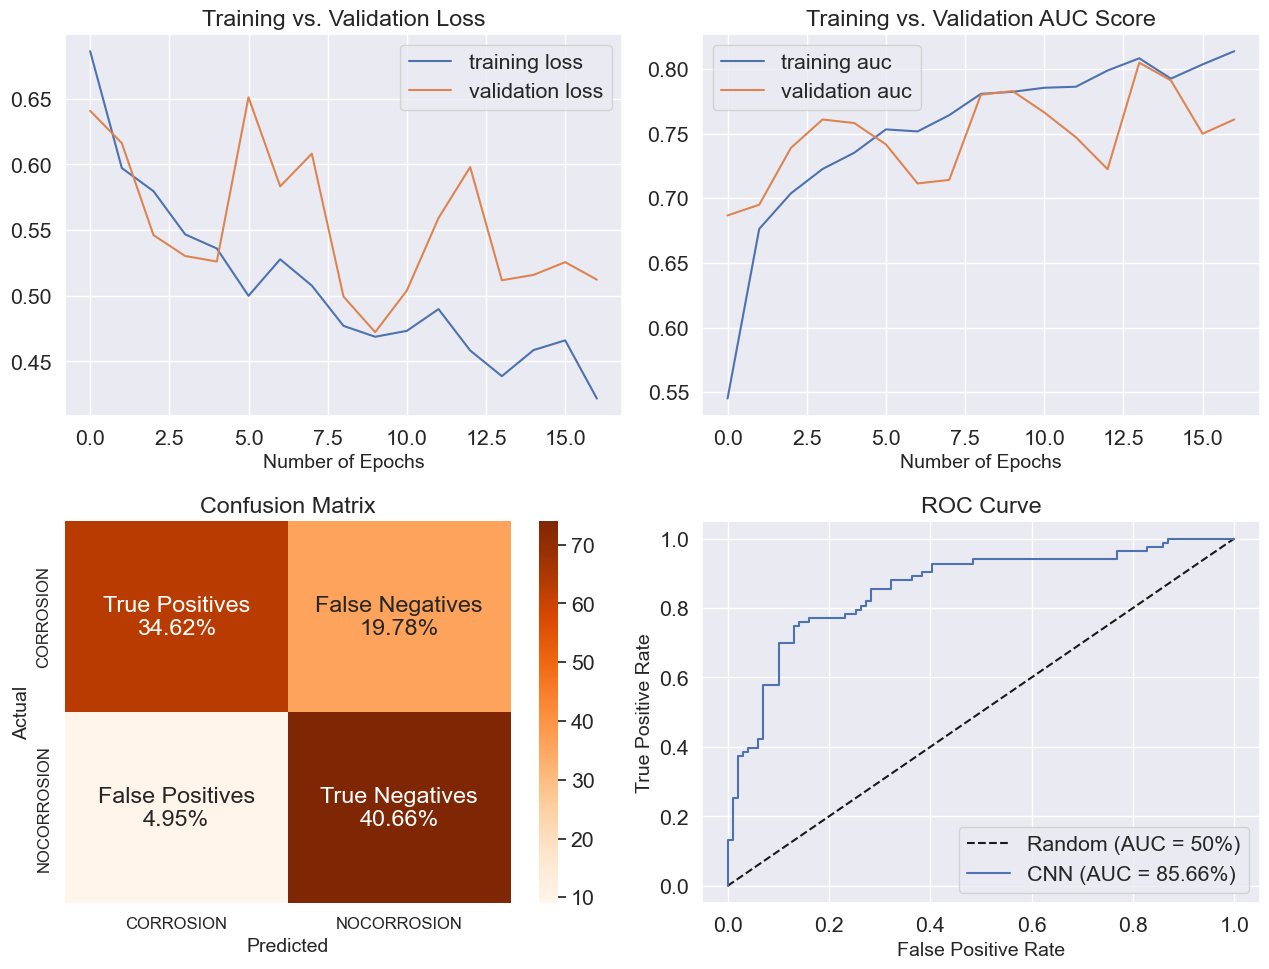

In [19]:
create_charts(cnn_3,cnn_model_3)

# Model4: Dropout = 0.1, Dropout = 0.2, Dropout = 0.2, Dropout =0.2, Dense layer = 128, Epoch = 50, Early Stopping

In [20]:
 # Design the model
    
def build_model_4():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    

    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_4 = build_model_4()

In [21]:
cnn_model_4 = cnn_4.fit_generator(train_generator,
                              epochs = 50,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_5340\76583179.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model_4 = cnn_4.fit_generator(train_generator,


Epoch 1/50
40/40 [==============================] - 49s 1s/step - loss: 0.6771 - acc: 0.6002 - val_loss: 0.6527 - val_acc: 0.7253
Epoch 2/50
40/40 [==============================] - 48s 1s/step - loss: 0.6159 - acc: 0.6921 - val_loss: 0.6082 - val_acc: 0.7335
Epoch 3/50
40/40 [==============================] - 46s 1s/step - loss: 0.5682 - acc: 0.7353 - val_loss: 0.5332 - val_acc: 0.7665
Epoch 4/50
40/40 [==============================] - 45s 1s/step - loss: 0.5484 - acc: 0.7266 - val_loss: 0.5185 - val_acc: 0.7720
Epoch 5/50
40/40 [==============================] - 45s 1s/step - loss: 0.5165 - acc: 0.7628 - val_loss: 0.5049 - val_acc: 0.7857
Epoch 6/50
40/40 [==============================] - 44s 1s/step - loss: 0.5069 - acc: 0.7604 - val_loss: 0.5010 - val_acc: 0.7637
Epoch 7/50
40/40 [==============================] - 46s 1s/step - loss: 0.4892 - acc: 0.7730 - val_loss: 0.5194 - val_acc: 0.7802
Epoch 8/50
40/40 [==============================] - 46s 1s/step - loss: 0.4981 - acc: 0.76

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_5340\2413494331.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 84.07% | Precision = 79.66% | Recall = 94.95% | Specificity = 71.08% | F1 Score = 86.64%


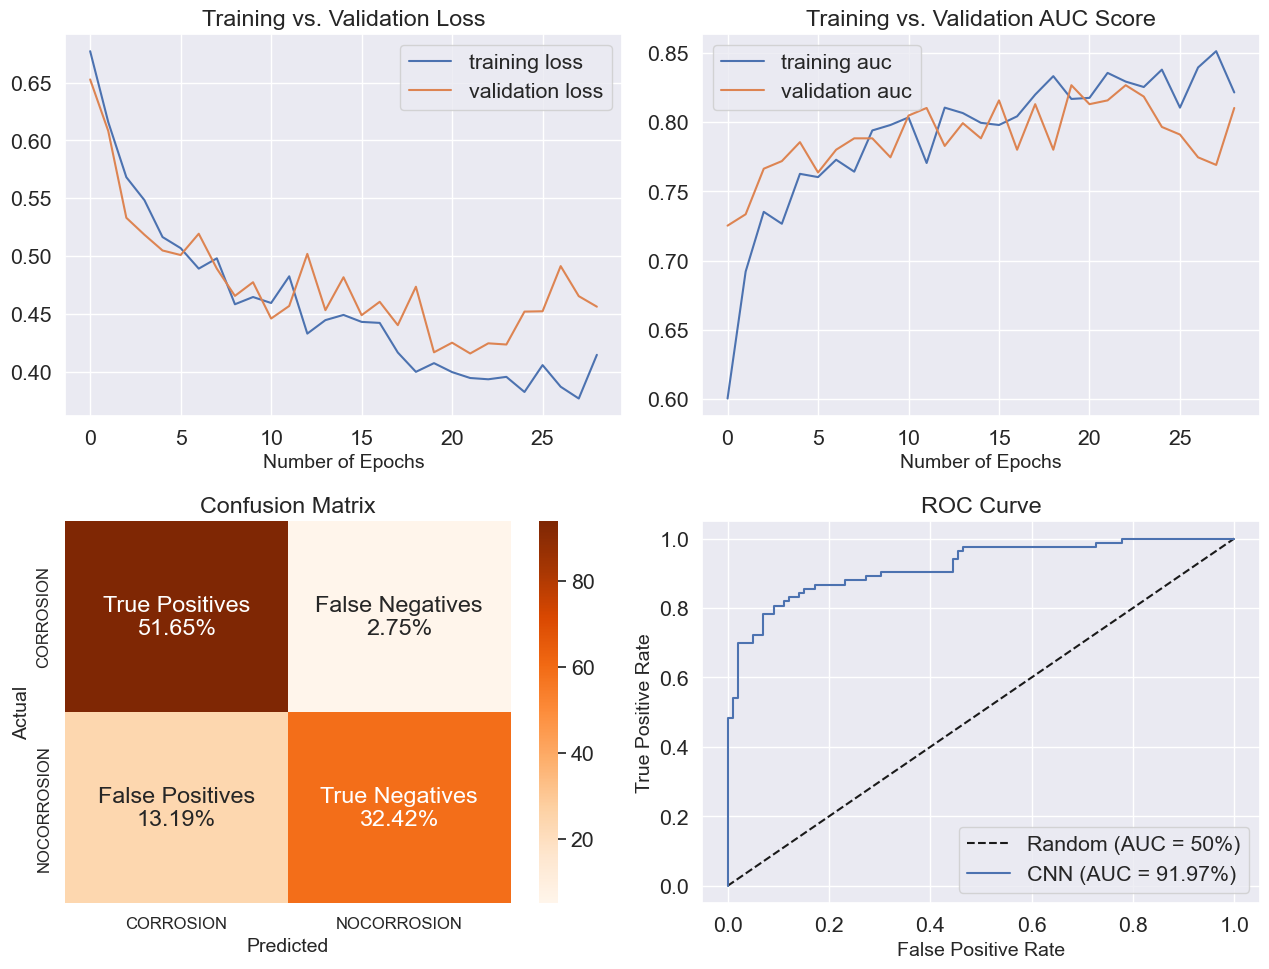

In [22]:
create_charts(cnn_4,cnn_model_4)